# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

### Clustering Shopping Centers in the Metropolitan Region of São Paulo

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Setup](#setup)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: <a name="introduction"></a>

     At this notebook, Foursquare API was used to cluster Shopping Malls in Sao Paulo regarding closely venues. The amount of venues per category in each Shopping Mall was acquired by an HTTP request to Foursquare API, and then used to group the Shopping Centers into clusters. For this notebook * k * -means clustering algorithm was selected to complete this task. Finally, Folium library has been used to view the neighborhoods in Sao Paulo and their emerging clusters.

    In addition to being the largest city in the country, São Paulo is the city with the largest number of shopping centers. Shopping centers are projects with a very special commercial vision, embodied in the joint strategy of convergent attractiveness for all business players, that is, investors, tenants, consumers, neighbors, the general public and even the public authorities. .

** The positive externality of Shopping Centers **

    Externality is understood as the possibility of a shopping mall, since it is inserted and installed within a neighborhood or micro-region, to positively influence a radius of stores in its surroundings. Because the simple presence of this shopping center, generates advantages for other tenants, who take advantage of the visit of consumers to those malls

    This characteristic is fully consigned by scholars, who recognize the attractiveness of consumers provided by large shopping centers, through the variety of products and services, incomparable advertising and recognized notoriety of these malls, generating confidence and determination in the purchase, which also reinforces the positive externality.
    
** Target audience **

    This project will help to understand the diversity of São Paulo Shopping Centers by leveraging venue data from Foursquare’s ‘Places API’ and ‘k-means clustering’ unsupervised machine learning algorithm. By analyzing this data we can ** classify the malls by the locations that are most frequent around those malls **. This data can be useful for entrepreneurs wishing to invest in some business close to Shopping Centers in São Paulo Capital.

## 1. Setup<a name="setup"></a>

At this first part, all code below is used to setup all libraries and settings from Notebook

### 1.1 Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import folium
import requests
import seaborn as sns
import matplotlib.pyplot as plt

!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

from pathlib import Path
from configparser import ConfigParser
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, HTML, Image

from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

---
## 2. Data
---

All data for Shopping Centers of São Paulo (Metro) was downloaded from RESTful FourSquare API to retrieve data about Shopping Malls, categories and venues in different areas. This is the <a href='https://developer.foursquare.com/docs'>link</a> to Foursquare API documentation for more details.

As mentioned Foursquare API is used to find all Shopping malls. To access the API, ‘CLIENT_ID’, ‘CLIENT_SECRET’ and ‘VERSION’ is defined in a credentials file, in order to get a credentials as well just sign up on the following [link](https://developer.foursquare.com/).

In [119]:
CLIENT_ID = # hided Foursquare ID
CLIENT_SECRET = # hided Foursquare Secret
ACCESS_TOKEN = # hided FourSquare Access Token
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JPSOA3FAWG4OPBJBET1OXFQAVVVDZGDX0VN5KTLVM4FWF1F3
CLIENT_SECRET:J34A5KYGOU0TYIIYUK2W40UPSAYBQP1HJ1YJIVDUBZ1ELE3N


Let´s define by star point the most important park of São Paulo, and get de latitude and longitude

In [120]:
adress = 'Parque Ibirapuera, São Paulo Brazil'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(adress)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

-23.58771265 -46.65852139371083


#### Get Response from Foursquare API

There are many endpoints available on Foursquare for various GET requests. But, to find Shopping Malls from São Paulo we can serch by category_id, which is retrieved using the code below.

In [121]:
categoryId = '4bf58dd8d48988d1fd941735'
radius = 15000
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&categoryId={}&radius={}&limit{}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, categoryId, radius, LIMIT)
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '6084332c093629540a616064'},
 'notifications': [{'type': 'notificationTray', 'item': {'unreadCount': 7}}],
 'response': {'venues': [{'id': '57da9cdc498e927cc8275f54',
    'name': 'Jardim Pamplona',
    'location': {'address': 'R. Pamplona, 1704',
     'crossStreet': 'Av. Nove de Julho',
     'lat': -23.57075710250764,
     'lng': -46.6607272013104,
     'labeledLatLngs': [{'label': 'display',
       'lat': -23.57075710250764,
       'lng': -46.6607272013104}],
     'distance': 1900,
     'postalCode': '01405-002',
     'cc': 'BR',
     'city': 'São Paulo',
     'state': 'SP',
     'country': 'Brasil',
     'formattedAddress': ['R. Pamplona, 1704 (Av. Nove de Julho)',
      'São Paulo, SP',
      '01405-002']},
    'categories': [{'id': '4bf58dd8d48988d1fd941735',
      'name': 'Shopping Mall',
      'pluralName': 'Shopping Malls',
      'shortName': 'Mall',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/mall_',
       'suffix'

#### Cleaning and converting into a dataframe

In [122]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
shopping = json_normalize(venues)
shopping.shape

<ipython-input-122-16939415a9a7>:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  shopping = json_normalize(venues)


(30, 19)

# Shoppings from São Paulo Data frame

In [123]:
# Selecting columns
shoppings = shopping.drop(columns=['location.address', 'categories', 'referralId', 'hasPerk', 'location.crossStreet', 'location.distance', 'location.postalCode', 'location.cc', 'location.neighborhood', 'location.city', 'location.state', 'location.country', 'location.labeledLatLngs','venuePage.id', 'location.formattedAddress'])

# Renaming columns
new_columns = ['id','name', 'latitude','longitude']

shoppings.columns = new_columns
shoppings.head()

,id,name,latitude,longitude
0,57da9cdc498e927cc8275f54,Jardim Pamplona,-23.570757,-46.660727
1,5b61de4bbcbf7a002cfe9531,Galeria Pão de Açucar Ricardo Jafet,-23.588138,-46.620347
2,4b07e75ff964a520f20023e3,Conjunto Nacional,-23.559015,-46.660070
3,4b23d94df964a520305b24e3,MorumbiShopping,-23.623372,-46.698976
4,4b07ed2cf964a520330123e3,Shopping Eldorado,-23.572872,-46.696171


#### Visualization

In [124]:
address = 'Sao Paulo, Sao Paulo Brazil'
geolocator = Nominatim(user_agent='get_location')

latitude = geolocator.geocode(address).latitude
longitude = geolocator.geocode(address).longitude

city_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, name in zip(shoppings['latitude']
                                               , shoppings['longitude']
                                               , shoppings['name']):
    
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
                            [lat, lng],
                            radius=5,
                            popup=label,
                            color='blue',
                            fill=True,
                            fill_color='#3186cc',
                            fill_opacity=0.7,
                            parse_html=False
                        ).add_to(city_map)  
city_map

### 2.2 Venues and Categories Data from Foursquare API

In order to find and explore venues and categories surrounding each Shopping Center, it has been used Foursquare API. Venues can be categorized. Let's see what venue categories Foursquare identifies.

Following example of a response from Foursquare API

In [125]:
# GET Response from Foursquare API

categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION)
category_results = requests.get(categories_url).json()
category_results = category_results['response']['categories']
category_results

[{'id': '4d4b7104d754a06370d81259',
  'name': 'Arts & Entertainment',
  'pluralName': 'Arts & Entertainment',
  'shortName': 'Arts & Entertainment',
  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_',
   'suffix': '.png'},
  'categories': [{'id': '56aa371be4b08b9a8d5734db',
    'name': 'Amphitheater',
    'pluralName': 'Amphitheaters',
    'shortName': 'Amphitheater',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_',
     'suffix': '.png'},
    'categories': []},
   {'id': '4fceea171983d5d06c3e9823',
    'name': 'Aquarium',
    'pluralName': 'Aquariums',
    'shortName': 'Aquarium',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/aquarium_',
     'suffix': '.png'},
    'categories': []},
   {'id': '4bf58dd8d48988d1e1931735',
    'name': 'Arcade',
    'pluralName': 'Arcades',
    'shortName': 'Arcade',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_ent

#### Categories

Upon analysis, it is found that there are 10 major or parent categories of venues,
under which all the other sub-categories are included. Following depiction shows
the ‘Category ID’ and ‘Category Name’ retrieved from API 

In [126]:
# Transforming Json to DataFrame
categories = pd.json_normalize(data=category_results)

# Cleaning DataFrame
categories = categories.drop(columns=['pluralName'
                             ,'shortName'
                             ,'categories'
                             ,'icon.prefix'
                             ,'icon.suffix'])

categories = categories.rename(columns={'id':'category_id',
                                         'name':'category_name'})
categories

,category_id,category_name
0,4d4b7104d754a06370d81259,Arts & Entertainment
1,4d4b7105d754a06372d81259,College & University
2,4d4b7105d754a06373d81259,Event
3,4d4b7105d754a06374d81259,Food
4,4d4b7105d754a06376d81259,Nightlife Spot
5,4d4b7105d754a06377d81259,Outdoors & Recreation
6,4d4b7105d754a06375d81259,Professional & Other Places
7,4e67e38e036454776db1fb3a,Residence
8,4d4b7105d754a06378d81259,Shop & Service
9,4d4b7105d754a06379d81259,Travel & Transport


#### Number of venues per category

As said earlier, the amount of venues per category for each Shopping Mall depiction is the matter of interest. A function is created to return a dataframe with ‘Category ID’, ‘Category Name’ and ‘Venues Quantity’ per ‘Shopping Name’. 

The function ‘get_venues_total’ is created. This functions loop through all the shoppings centers of Sao Paulo and creates an API request URL with radius = 500. Further, the GET request is made to Foursquare API and the data is then appended to a python dataframe. Lastly, the python dataframe is returned by the function.

In [127]:
def get_venues_total(CLIENT_ID, CLIENT_SECRET, VERSION, lat, long, radius, category_id): 
    ''' Function which returns number of venues considering a Foursquare category and radius '''
    
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}'.format(
                    CLIENT_ID,
                    CLIENT_SECRET,
                    VERSION, 
                    lat,
                    long,
                    radius,
                    category_id)
  
    try:
        response = requests.get(explore_url).json()['response']['totalResults']
  
    except:
        response = 0
        
    return response

In [128]:
shoppings_venues = []

for index, shopping in shoppings.iterrows():
    for index_2, category in categories.iterrows():
        shoppings_venues.append([(shopping['name']
                                , shopping['latitude']
                                , shopping['longitude']
                                , category['category_name'] 
                                , get_venues_total(CLIENT_ID 
                                                   ,CLIENT_SECRET 
                                                   ,VERSION
                                                   ,lat = shopping['latitude']
                                                   ,long = shopping['longitude']
                                                   ,radius = 1000
                                                   ,category_id = category['category_id']))])
    
shoppings_venues = pd.DataFrame([item for shoppings_venues in shoppings_venues for item in shoppings_venues])
shoppings_venues.columns=['name', 'latitude', 'longitude', 'category_name', 'venues']

# Exporting to .CSV
shoppings_venues.to_csv('results_from_api.csv', index=False)
shoppings_venues.tail()

,name,latitude,longitude,category_name,venues
295,Shopping Butantã,-23.58529,-46.725004,Outdoors & Recreation,38
296,Shopping Butantã,-23.58529,-46.725004,Professional & Other Places,42
297,Shopping Butantã,-23.58529,-46.725004,Residence,12
298,Shopping Butantã,-23.58529,-46.725004,Shop & Service,61
299,Shopping Butantã,-23.58529,-46.725004,Travel & Transport,10


---
## 3. Methodology<a name="methodology"></a>
---

In [3]:
shoppings_venues = pd.read_csv('../data/results_from_api.csv')

### 3.1 Descriptive Analysis<a name="analysis"></a>

In [5]:
shoppings_venues.groupby('category_name')['venues'].describe().T.round()

category_name,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
count,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0
mean,17.0,28.0,5.0,114.0,29.0,41.0,62.0,17.0,86.0,23.0
std,17.0,20.0,5.0,51.0,29.0,22.0,28.0,12.0,20.0,24.0
min,3.0,5.0,0.0,44.0,4.0,7.0,21.0,2.0,42.0,3.0
25%,6.0,15.0,2.0,72.0,8.0,21.0,44.0,8.0,72.0,8.0
50%,10.0,20.0,4.0,106.0,19.0,42.0,58.0,14.0,90.0,13.0
75%,23.0,38.0,6.0,152.0,37.0,60.0,79.0,23.0,98.0,27.0
max,79.0,79.0,19.0,226.0,115.0,80.0,140.0,44.0,119.0,85.0


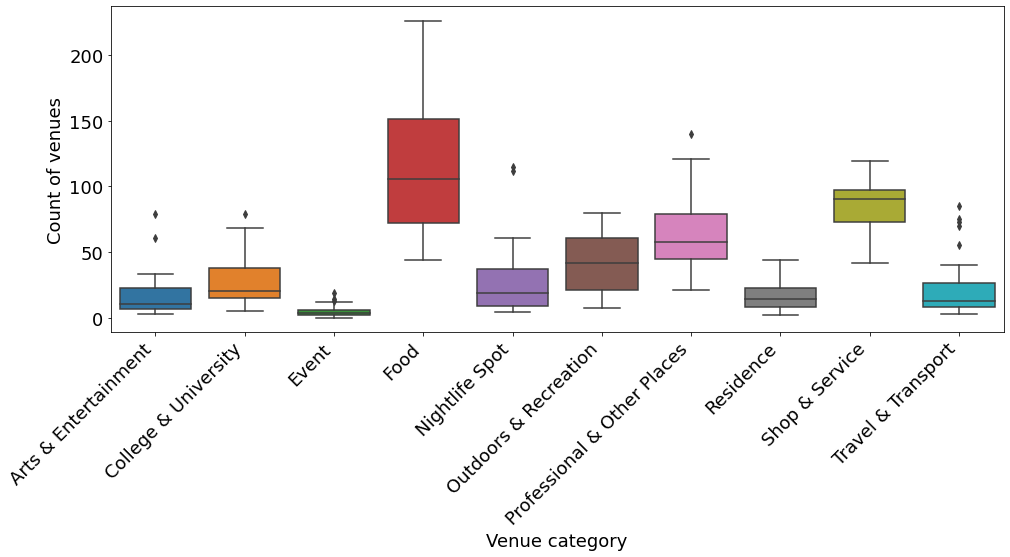

In [7]:
plt.figure(figsize=(16, 6))

ax = sns.boxplot(x="category_name", y="venues", data=shoppings_venues)
ax.set_ylabel('Count of venues', fontsize=18)
ax.set_xlabel('Venue category', fontsize=18)
ax.tick_params(labelsize=18)
plt.xticks(rotation=45, ha='right')

plt.show()

As we can see, the category **Event** has fewer venues, therefore, it has been not considered for the further clustering method.

In [8]:
df = pd.pivot_table(shoppings_venues
                    , index=['name','latitude', 'longitude']
                    , columns='category_name'
                    , values='venues', ).reset_index()

# Excluding Event Category from the analysis
df = df.drop(columns=['Event'])

df = df.rename_axis(None, axis=1)
df

,name,latitude,longitude,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Bourbon Shopping,-23.526457,-46.681090,32,29,122,61,61,67,19,90,17
1,Centro Empresarial de São Paulo (CENESP),-23.648682,-46.730532,7,6,85,6,18,64,3,67,13
2,Conjunto Nacional,-23.559015,-46.660070,61,59,202,115,80,121,33,116,85
3,Fabbrica Mooca,-23.550453,-46.595544,6,39,117,35,41,51,24,47,10
4,Galeria Pão de Açucar Ricardo Jafet,-23.588138,-46.620347,7,16,68,14,35,36,17,63,13
5,Grand Plaza Shopping,-23.649493,-46.531662,9,52,134,32,24,66,15,74,13
6,Jardim Pamplona,-23.570757,-46.660727,33,35,140,38,64,80,25,74,55
7,Morumbi Open Center,-23.641594,-46.743189,3,9,57,13,20,36,9,42,8
8,Morumbi Town,-23.631747,-46.737363,11,15,46,5,48,57,44,96,9
9,MorumbiShopping,-23.623372,-46.698976,10,34,150,23,50,85,19,113,21


### 3.3 Feature Engineering

Let’s normalize the data using [min-max scaling](https://en.wikipedia.org/wiki/Feature_scaling#Rescaling_(min-max_normalization)) (scale count of venues from 0 to 1 where 0 is the lowest value in a set and 1 is highest). This both normalizes the data and provides an easy to interpret score at the same time. The scaled box plot was ploted below:

In [9]:
cluster_dataset = df.iloc[:,3:]
category_list = cluster_dataset.columns

X = cluster_dataset.values
cluster_dataset = pd.DataFrame(MinMaxScaler().fit_transform(X))
cluster_dataset.columns = category_list

cluster_dataset = cluster_dataset.reset_index(drop=True)
cluster_dataset

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,0.381579,0.324324,0.428571,0.513514,0.739726,0.386555,0.404762,0.623377,0.170732
1,0.052632,0.013514,0.225275,0.018018,0.150685,0.361345,0.023810,0.324675,0.121951
2,0.763158,0.729730,0.868132,1.000000,1.000000,0.840336,0.738095,0.961039,1.000000
3,0.039474,0.459459,0.401099,0.279279,0.465753,0.252101,0.523810,0.064935,0.085366
4,0.052632,0.148649,0.131868,0.090090,0.383562,0.126050,0.357143,0.272727,0.121951
5,0.078947,0.635135,0.494505,0.252252,0.232877,0.378151,0.309524,0.415584,0.121951
6,0.394737,0.405405,0.527473,0.306306,0.780822,0.495798,0.547619,0.415584,0.634146
7,0.000000,0.054054,0.071429,0.081081,0.178082,0.126050,0.166667,0.000000,0.060976
8,0.105263,0.135135,0.010989,0.009009,0.561644,0.302521,1.000000,0.701299,0.073171
9,0.092105,0.391892,0.582418,0.171171,0.589041,0.537815,0.404762,0.922078,0.219512


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Arts & Entertainment'),
  Text(1, 0, 'College & University'),
  Text(2, 0, 'Food'),
  Text(3, 0, 'Nightlife Spot'),
  Text(4, 0, 'Outdoors & Recreation'),
  Text(5, 0, 'Professional & Other Places'),
  Text(6, 0, 'Residence'),
  Text(7, 0, 'Shop & Service'),
  Text(8, 0, 'Travel & Transport')])

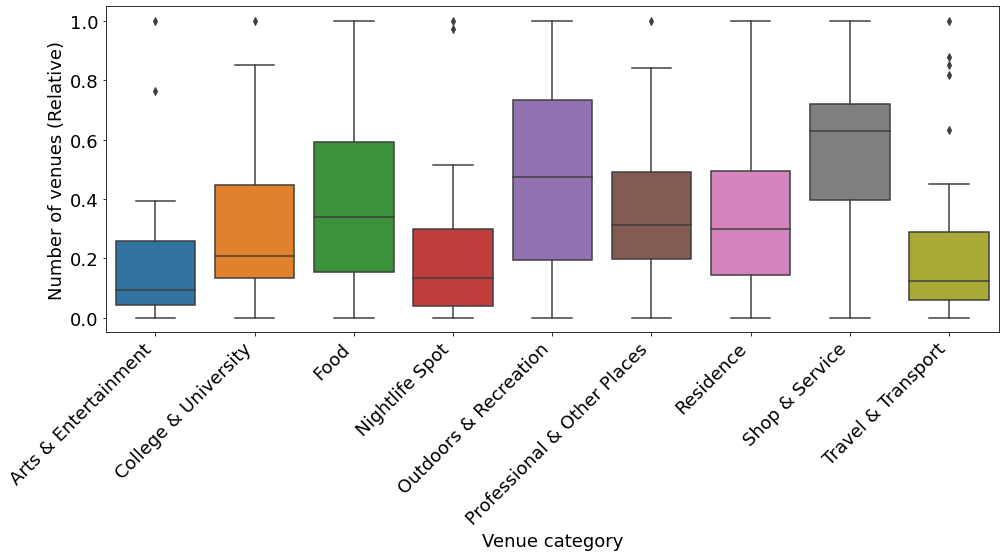

In [10]:
plt.figure(figsize=(16, 6))

ax = sns.boxplot(data=cluster_dataset)
ax.set_ylabel('Number of venues (Relative)', fontsize=18)
ax.set_xlabel('Venue category', fontsize=18)
ax.tick_params(labelsize=18)

plt.xticks(rotation=45, ha='right')

### 3.4 K-Means Clustering

'K-Means' is an unsupervised machine learning algorithm that creates clusters of data points aggregated together because of certain similarities. This algorithm will be used to count venues for each cluster label for variable cluster size. To implement this algorithm, it is very important to determine the optimal number of clusters (i.e. k). There are 2 most popular methods for the same, namely [‘The Elbow Method’ and ‘The Silhouette Method’](https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb), for this project will be used 'The Elbow Method'.

#### The Elbow Method

The Elbow Method calculates the sum of squared distances of samples to their closest cluster center for different values of 'k'. The optimal number of clusters is the value after which there is no significant decrease in the sum of squared distances. Following is an implementation of this method (with varying number of clusters from 1 to 20):

Sometimes, Elbow method does not give the required result, which did not happen in this case. If there was a gradual decrease in the sum of squared distances, an optimal number of clusters could not be determined. To counter this, another method can be implemented, such as the Silhouette Method.
Following below the code and the plot obtained:

1 2 3 4 5 6 7 8 9 

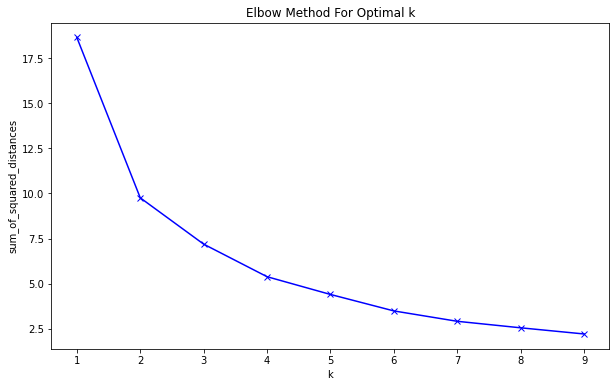

In [11]:
sum_of_squared_distances = []
K = range(1,10)

for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=20).fit(cluster_dataset)
    sum_of_squared_distances.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k');

The Elbow Method determines an optimal number of cluster of **3**

In [14]:
for i in range(2,10):
  kmeans_ = KMeans(n_clusters=i).fit(cluster_dataset)
  labels_ = kmeans_.labels_
  coef = silhouette_score(cluster_dataset,labels_)
  
  print("N_cluster: {}, score: {}".format(i,coef))


N_cluster: 2, score: 0.39565629485730996
N_cluster: 3, score: 0.3620081702974536
N_cluster: 4, score: 0.4021281786556042
N_cluster: 5, score: 0.3349777185860193
N_cluster: 6, score: 0.35059222720090494
N_cluster: 7, score: 0.354007812074146
N_cluster: 8, score: 0.30277953090771903
N_cluster: 9, score: 0.30456482365098553


The score of the kmeans metod determines an optimal number of cluster of **4**

#### K-Means

After testing clustering with 4 clusters and 3 clusters, the only difference noted was the creation of a new cluster with only 2 malls, or any apparent motivation. As we do not have many malls to cluster, I will choose to create 3 clusters.

Following code block runs the k-Means algorithm with number of **clusters = 3** and prints the counts of shoppings centers assigned to different clusters: 

In [15]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, n_init=20).fit(cluster_dataset)

kmeans_labels = kmeans.labels_

df_clusters = df.copy()
df_clusters['cluster'] = kmeans_labels
df_clusters['latitude'] = df['latitude']
df_clusters['longitude'] = df['longitude']

df_clusters_minmax = cluster_dataset.copy()
df_clusters_minmax['cluster'] = kmeans_labels
df_clusters_minmax['name'] = df['name']

# Exporting to .CSV
df_clusters.to_csv('../data/df_clusters.csv', index=False)

df_clusters_minmax

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,cluster,name
0,0.381579,0.324324,0.428571,0.513514,0.739726,0.386555,0.404762,0.623377,0.170732,2,Bourbon Shopping
1,0.052632,0.013514,0.225275,0.018018,0.150685,0.361345,0.023810,0.324675,0.121951,0,Centro Empresarial de São Paulo (CENESP)
2,0.763158,0.729730,0.868132,1.000000,1.000000,0.840336,0.738095,0.961039,1.000000,1,Conjunto Nacional
3,0.039474,0.459459,0.401099,0.279279,0.465753,0.252101,0.523810,0.064935,0.085366,0,Fabbrica Mooca
4,0.052632,0.148649,0.131868,0.090090,0.383562,0.126050,0.357143,0.272727,0.121951,0,Galeria Pão de Açucar Ricardo Jafet
5,0.078947,0.635135,0.494505,0.252252,0.232877,0.378151,0.309524,0.415584,0.121951,0,Grand Plaza Shopping
6,0.394737,0.405405,0.527473,0.306306,0.780822,0.495798,0.547619,0.415584,0.634146,2,Jardim Pamplona
7,0.000000,0.054054,0.071429,0.081081,0.178082,0.126050,0.166667,0.000000,0.060976,0,Morumbi Open Center
8,0.105263,0.135135,0.010989,0.009009,0.561644,0.302521,1.000000,0.701299,0.073171,0,Morumbi Town
9,0.092105,0.391892,0.582418,0.171171,0.589041,0.537815,0.404762,0.922078,0.219512,2,MorumbiShopping


---
## 4. Results<a name="results"></a>
---

### 4.1 K-Means Results

After getting the result DataFrame, It has been displayed the boxplot below. It's noticed that the major difference between clusters was related to how 'crowded' of venues is the Shoppings surrounding. For example, Cluster 3 has a higher number of venues (relative) medians, when compared to other clusters. Then, we could imply that shoppings malls from Cluster 3 have more venues density in a 1000m radius than any other shopping malls from other clusters.

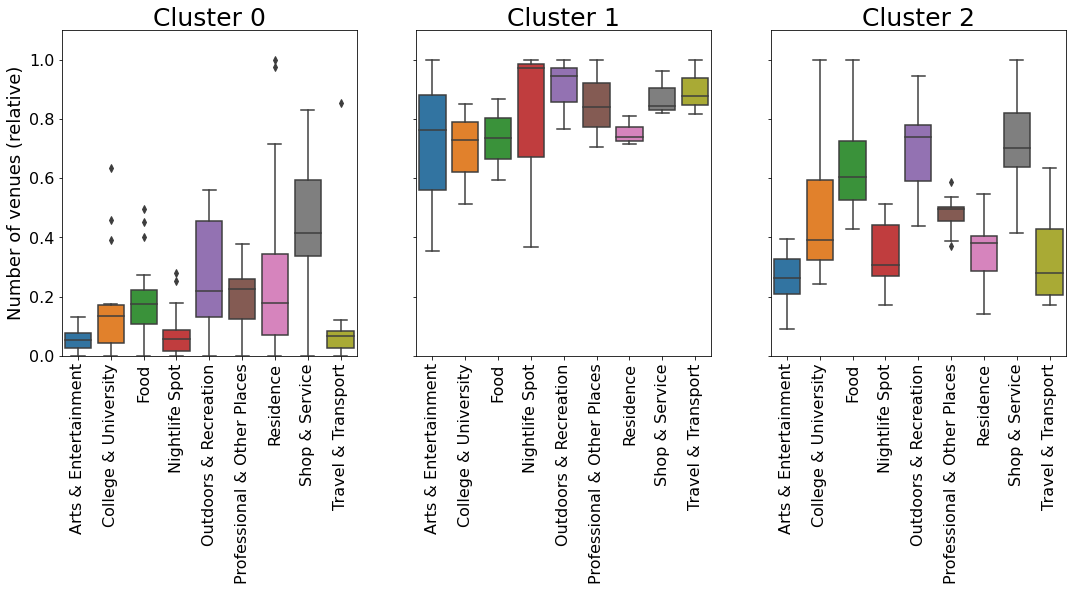

In [16]:
fig, axes = plt.subplots(1, kclusters, figsize=(18, 6), sharey=True )

axes[0].set_ylabel('Number of venues (relative)', fontsize=18)

for k in range(kclusters):
    #Set same y axis limits
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=16)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data = df_clusters_minmax[df_clusters_minmax['cluster'] == k].drop(columns='cluster'), ax=axes[k])

plt.show()

In [17]:
address = 'Sao Paulo, Sao Paulo Brazil'
geolocator = Nominatim(user_agent='get_location')

latitude = geolocator.geocode(address).latitude
longitude = geolocator.geocode(address).longitude

categories_list = cluster_dataset.columns

# set color scheme for the clusters
rainbow = ['#4c6ca5'
           , '#3c8447'
           , '#b40049'
           , '#864ca5']

city_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
markers_colors = []
for i, lat, lng, name, cluster in zip(df_clusters.index
                                              , df_clusters['latitude']
                                              , df_clusters['longitude']
                                              , df_clusters['name']
                                              , df_clusters['cluster']):
  
    #Calculate top 3 categories for each shopping
    shopping_series = df_clusters.iloc[i]
    top_categories_dict = {}

    for cat in categories_list:
        top_categories_dict[cat] = shopping_series[cat]
        
    top_categories = sorted(top_categories_dict.items(), key=lambda x: x[1], reverse=True)
  
    popup='<b>{}</b><br>Cluster {}<br>1. {} {}<br>2. {} {}<br>3. {} {}'.format(
          name,
          cluster,
          top_categories[0][0],
          "{0:.2f}".format(top_categories[0][1]),
          top_categories[1][0],
          "{0:.2f}".format(top_categories[1][1]),
          top_categories[2][0],
          "{0:.2f}".format(top_categories[2][1]))
  
    label = folium.Popup(popup, parse_html=True)

    folium.CircleMarker(
                          [lat, lng],
                          radius=5,
                          popup=label,
                          color=rainbow[cluster-1],
                          fill=True,
                          fill_color=rainbow[cluster-1],
                          fill_opacity=0.7,
                          parse_html=False).add_to(city_map)  
    
city_map

In the map above the division of clusters we can see that the malls were grouped according to their main characteristics, as explained below:


**Summary:**

+ **Cluster 1 (Blue)** - 3 Shoppings Malls

    Shoppings within cluster 1 have a higher frequency of venues and contain Sao Paulo Downtown Neighborhoods (Praca da Se, Republica e Anhangabau) and important streets in Sao Paulo (Av. Paulista, Faria Lima, Reboucas and Oscar Freire). Those streets have headquarters of many financial and cultural institutions, it's known the financial capital of Brazil. Usually, those areas have a higher frequency of Professional, Food, Shop and Service venues. Larger even than the establishment of the malls themselves.


+ **Cluster 2 (Green)** - 9 Shoppings Malls

    Shoppings within cluster 1 do not have the highest frequency of venues in Sao Paulo. However, It's close to Downtown and Financial Center of Sao Paulo. Neighborhoods close to those malls are also super important in Sao Paulo, many companies have headquarters and important places in Sao Paulo are located in this areas. And it also has great restaurant areas such as Moema and Itaim.


+ **Cluster 0 (Purple)** - 18 Shoppigs Malls 

    It is the biggest cluster on this analysis with 18 Shopping Malls, this area contains malls that are further from downtown and financial center in São Paulo. With a high frequency of 'Shop & Service' and 'Food', which signals malls with little concentration of locations outside the mall.

    

As explained before K-means was able to cluster shopping malls by using their surrounding venues, and it has been produced Four different clusters as shown below. Those areas are different from each other mainly due to venue concentration. Malls that are more close to downtown has more venues within 1000m radius than malls further to the center.

#### Cluster 0 (Purple)

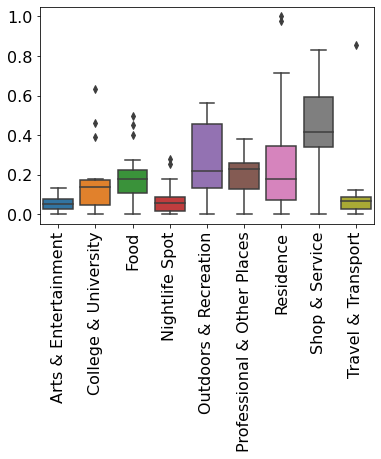

In [18]:
# Cluster 0 lilás

# Mais afastados do centro com alta frequencia de estabelecimentos diretamente relacionados aos Shoppings e
# baixa frequencia de outros estabelecimentos
k = 0

#Set same y axis limits
figsize=(10, 6)
plt.tick_params(labelsize=16)
plt.xticks(rotation='vertical')


#Set same y axis limits
sns.boxplot(data = df_clusters_minmax[df_clusters_minmax['cluster'] == k].drop('cluster',1))

plt.show()

In [19]:
df_cluster_k = df_clusters_minmax[df_clusters_minmax['cluster'] == 0]

# Reordering Columns
df_cluster_k = df_cluster_k[['name'
                             , 'Shop & Service'
                             , 'Food'
                             ,'Professional & Other Places'
                             , 'Arts & Entertainment'
                             , 'College & University'
                             , 'Nightlife Spot'
                             ,'Outdoors & Recreation'
                             , 'Residence'
                             , 'Travel & Transport']].sort_values(by='name').reset_index(drop=True)

df_cluster_k

,name,Shop & Service,Food,Professional & Other Places,Arts & Entertainment,College & University,Nightlife Spot,Outdoors & Recreation,Residence,Travel & Transport
0,Centro Empresarial de São Paulo (CENESP),0.324675,0.225275,0.361345,0.052632,0.013514,0.018018,0.150685,0.023810,0.121951
1,Fabbrica Mooca,0.064935,0.401099,0.252101,0.039474,0.459459,0.279279,0.465753,0.523810,0.085366
2,Galeria Pão de Açucar Ricardo Jafet,0.272727,0.131868,0.126050,0.052632,0.148649,0.090090,0.383562,0.357143,0.121951
3,Grand Plaza Shopping,0.415584,0.494505,0.378151,0.078947,0.635135,0.252252,0.232877,0.309524,0.121951
4,Morumbi Open Center,0.000000,0.071429,0.126050,0.000000,0.054054,0.081081,0.178082,0.166667,0.060976
5,Morumbi Town,0.701299,0.010989,0.302521,0.105263,0.135135,0.009009,0.561644,1.000000,0.073171
6,Open Mall Panamby,0.636364,0.153846,0.243697,0.078947,0.135135,0.018018,0.506849,0.714286,0.036585
7,ParkShoppingSãoCaetano,0.467532,0.098901,0.000000,0.000000,0.040541,0.000000,0.205479,0.071429,0.000000
8,Shopping Anália Franco,0.701299,0.192308,0.260504,0.052632,0.175676,0.018018,0.342466,0.071429,0.024390
9,Shopping Aricanduva,0.376623,0.153846,0.058824,0.013158,0.027027,0.072072,0.123288,0.119048,0.060976


#### Cluster 1 (Blue)

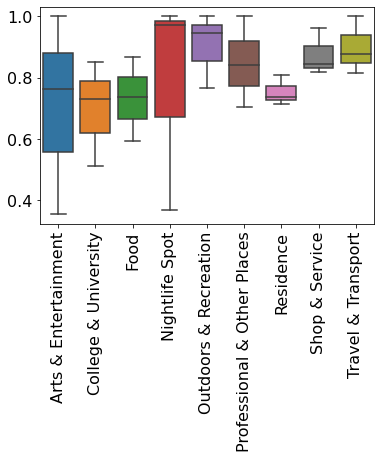

In [20]:
# Cluster 1 Azul

# região central de São Paulo com alta concentração de serviços, maiores até que os próprios serviços e lojas ofertadas
# pelos shoppings
k = 1

#Set same y axis limits
figsize=(10, 6)
plt.tick_params(labelsize=16)
plt.xticks(rotation='vertical')

#Set same y axis limits
sns.boxplot(data = df_clusters_minmax[df_clusters_minmax['cluster'] == k].drop('cluster',1))

plt.show()

In [21]:
df_cluster_k = df_clusters_minmax[df_clusters_minmax['cluster'] == 1]

# Reordering Columns
df_cluster_k = df_cluster_k[['name'
                             , 'College & University'
                             , 'Food'
                             , 'Nightlife Spot'
                             ,'Outdoors & Recreation'
                             ,'Professional & Other Places'
                             , 'Residence'
                             , 'Travel & Transport']].sort_values(by='name').reset_index(drop=True)

df_cluster_k

,name,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Travel & Transport
0,Conjunto Nacional,0.729730,0.868132,1.000000,1.000000,0.840336,0.738095,1.000000
1,Shopping Frei Caneca,0.851351,0.593407,0.972973,0.945205,0.705882,0.809524,0.817073
2,Shopping Pátio Paulista,0.513514,0.736264,0.369369,0.767123,1.000000,0.714286,0.878049


#### Cluster 2 (Green)

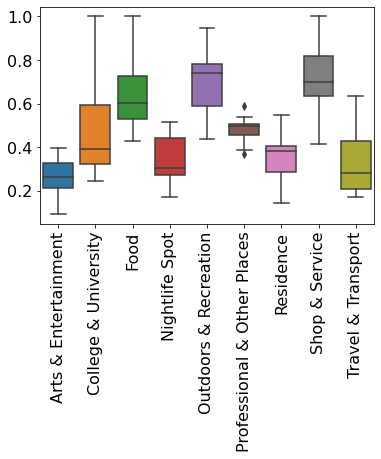

In [22]:
# Cluster 2 Verde

# 

k = 2

#Set same y axis limits
figsize=(10, 6)
plt.tick_params(labelsize=16)
plt.xticks(rotation='vertical')

#Set same y axis limits
sns.boxplot(data = df_clusters_minmax[df_clusters_minmax['cluster'] == k].drop('cluster',1))

plt.show()

In [23]:
df_cluster_k = df_clusters_minmax[df_clusters_minmax['cluster'] == 2]

# Reordering Columns
df_cluster_k = df_cluster_k[['name'
                             , 'College & University'
                             , 'Food'
                             , 'Nightlife Spot'
                             ,'Outdoors & Recreation'
                             ,'Professional & Other Places'
                             , 'Residence'
                             , 'Travel & Transport']].sort_values(by='name').reset_index(drop=True)

df_cluster_k

,name,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Travel & Transport
0,Bourbon Shopping,0.324324,0.428571,0.513514,0.739726,0.386555,0.404762,0.170732
1,Jardim Pamplona,0.405405,0.527473,0.306306,0.780822,0.495798,0.547619,0.634146
2,MorumbiShopping,0.391892,0.582418,0.171171,0.589041,0.537815,0.404762,0.219512
3,Shopping Eldorado,0.310811,1.000000,0.432432,0.547945,0.453782,0.214286,0.451220
4,Shopping Ibirapuera,0.364865,0.725275,0.441441,0.808219,0.369748,0.285714,0.426829
5,Shopping Iguatemi,0.243243,0.505495,0.270270,0.739726,0.470588,0.142857,0.292683
6,Shopping Metrô Santa Cruz,0.662162,0.604396,0.234234,0.712329,0.588235,0.380952,0.207317
7,Shopping Metrô Tatuapé,0.594595,0.637363,0.279279,0.438356,0.504202,0.357143,0.182927
8,Shopping Pátio Higienópolis,1.000000,0.818681,0.477477,0.945205,0.495798,0.380952,0.280488


---
## 5. Discussion
---




The purpose of this project was to cluster different Shoppings Malls in Sao Paulo based on the surrounding areas of every mall. For that, Foursquare API venue data was used. Foursquare data isn't all-encompassing since data doesn't take into account a venue's size (e.g. a big restaurant attracts a lot more people that a hot dog stand - each of them is still one Foursquare "venue").
Another possible development is to include more data e.g housing prices and criminality and passenger per mall it would be interesting to add this kind of information to the analysis. This could potentially be valuable for getting more detailed clusters and a profile of each Shopping Mall helping entrepreneurs to take better decisions.

---
## 6. Conclusion<a name="conclusion"></a>
---

Four clusters were identified. The main differences between the clusters are the average number of venues per Shoppings Centers and the most common venues surrounding it are Shop & Service, Food and Professional & Other Places. K-Means clustering method was able to separate the malls by a number of venues within a 1000m radius and showed that Sao Paulo has a group of malls that have few locations around them, but many locations working within the malls, malls that are located in more central areas and therefore with a complete offer of locations both outside and inside the malls and finally those malls that are located in more upscale areas of the city and therefore have an interesting number of establishments taking advantage of the externality propagated by these malls.

As an insight for a deeper analysis I would highlight cluster 2, green in color, 9 malls, as it has an interesting number of locations inside and outside the mall, but even less than the frequency of locations found in cluster 1, and higher external frequency than verified by cluster 0, signaling a good indication of the spread of externality generated by these malls.